In [24]:
import numpy as np
from numpy import random, cos, sin, sqrt, pi
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from numpy.linalg import multi_dot, eig, eigh
import inspect
import sklearn.metrics.pairwise as skp
import zipfile, os, pickle

In [2]:
def disturb(x, n, sigma):
    eps = random.normal(loc=0, scale=sigma, size=n)
    return x + eps

def set_options(ax):
    ax.grid(False)
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
def rand_sphere(n, r, sigma):
    z = r * (2 * random.rand(n) - 1)   # uniform in -r, r
    t = 2 * pi * random.rand(n)   # uniform in 0, 2*pi
    x = sqrt(r**2 - z**2) * cos(t)
    y = sqrt(r**2 - z**2) * sin(t)
    x = disturb(x, n, sigma); y = disturb(y, n, sigma); z = disturb(z, n, sigma)
    return x, y, z

def synthetic_noise(N, r1, r2, sigma, show=True):    
    p1 = rand_sphere(int(N/2), r1, sigma)
    p2 = rand_sphere(int(N/2), r2, sigma)
    data1 = pd.DataFrame({'V1': p1[0], 'V2': p1[1], 'V3': p1[2], 'Y': np.ones(p1[0].shape).astype(int)})
    data2 = pd.DataFrame({'V1': p2[0], 'V2': p2[1], 'V3': p2[2], 'Y': (2*np.ones(p2[0].shape)).astype(int)})
    data = pd.concat((data1, data2), axis=0)
    data = data.sample(frac=1).reset_index(drop=True)
    if show:
        x, y, z = p1
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, label='Class 1')
        x, y, z = p2
        ax.scatter(x, y, z, label='Class 2')
        set_options(ax)
        plt.legend(); plt.show()
    return data

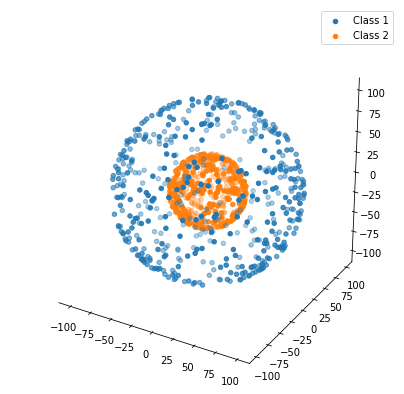

In [3]:
data = np.array(synthetic_noise(1000, 100, 40, 0))

Kernel PCA

In [6]:
def centering(K):
    """
    Center kernel
    :param K: np.array
    :return: np.array
    """
    n = K.shape[0]
    B = np.eye(n) - np.ones((n, n))/n
    return multi_dot([B, K, B])

def gaussian(X, sigma=27.8):
    return skp.rbf_kernel(X, gamma=0.5/sigma**2)

def polynomial(X, d):
    return skp.polynomial_kernel(X, degree=d)

In [38]:
class kernelPCA():
    def __init__(self, method, params, p):
        self.method = method
        self.params = params
        self.p = p
        
    def fit(self, X_train):
        self.X_train = X_train
        print('...Computing Gram matrix...')
        self.K = self.getK(X_train)
        print('...Computing eigenvectors...')
        eigVl, eigVc = self.getEigs(self.K)
        eigVc /= np.sqrt(eigVl)
        self.alpha = eigVc
        
    def fit_transform(self, X_train):
        self.fit(X_train)
        new_X = self.newData(X_train)
        print('...Projecting onto a{:3.0f}-dimensional space...'.format(self.p))
        for i in range(X_train.shape[0]):
            Ki = self.K[i]
            for k in range(self.p):
                new_X.iloc[i, k] = np.dot(Ki, self.alpha[:, k])
        return new_X
    
    def transform(self, X_test):
        new_X = self.newData(X_test)
        self.X_test = X_test
        print('...Projecting on test...')
        for i, x_test in enumerate(self.X_test[:, :-1]):
            v = []
            for j, x_train in enumerate(self.X_train[:, :-1]):
                v.append(self.phi(x_test, x_train))
            for k in range(self.p):
                new_X.iloc[i, k] = np.dot(np.array(v), self.alpha[:, k])
        return new_X
    
    def newData(self, X):
        n = X.shape[0]
        z = np.zeros(n)
        dict_ = dict(zip(['a'+str(i) for i in range(self.p)], [z]*self.p))
        dict_['Y'] = X[:, -1]
        new_X = pd.DataFrame(dict_)
        return new_X
        
    def getEigs(self, K):
        eigenValues, eigenVectors = eigh(K)
        idx = eigenValues.argsort()[::-1][:self.p]
        return eigenValues[idx], eigenVectors[:, idx]

    def getK(self, X):
        if self.method.__name__ == 'gaussian':
            sigma = self.params['sigma']
            K = centering(gaussian(X, sigma=sigma))
            self.phi = lambda x,y : np.exp(-0.5 * np.linalg.norm(x-y, ord=2)**2 / sigma**2)
        elif self.method.__name__ == 'polynomial':
            d = self.params['d']
            K = centering(polynomial(X, d=d))
            self.phi = lambda x,y : np.dot(x, y)**d
        return K
    
def plot_results(data, figsize, titles, grid):
    plt.figure(figsize=figsize)
    Y = data[0].iloc[:, -1]
    for j, X in enumerate(data):
        plt.subplot(grid[0], grid[1], j+1)
        for i in Y.unique():
            class_ = X[Y == i]
            x, y = class_.a0, class_.a1
            plt.scatter(x, y, label='Class '+str(int(i)))
        plt.legend(loc='best')
        plt.title(titles[j])
    plt.show()

...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...


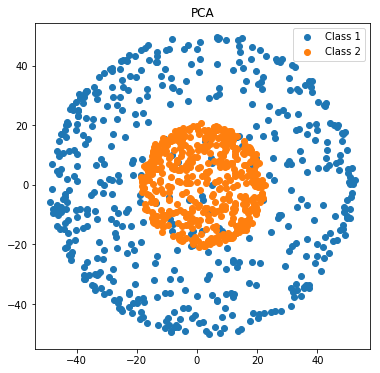

In [19]:
data = np.array(synthetic_noise(1000, 100, 40, 1, False))
method = polynomial
kpca = kernelPCA(method, {'d': 1}, 2)
train_new = kpca.fit_transform(data)
plot_results([train_new], figsize=(6, 6), titles=['PCA'], grid=(1, 1))

...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...


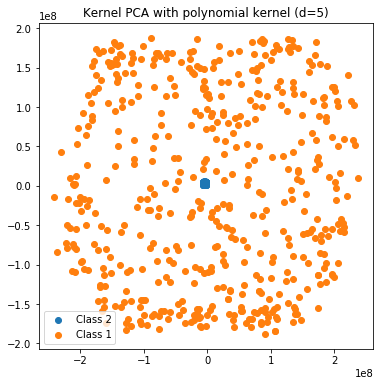

In [18]:
method = polynomial
kpca = kernelPCA(method, {'d': 5}, 2)
train_new = kpca.fit_transform(data)
plot_results([train_new], figsize=(6, 6), titles=['Kernel PCA with polynomial kernel (d=5)'], grid=(1, 1))

...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...
...Computing Gram matrix...
...Computing eigenvectors...
...Projecting onto a  2-dimensional space...


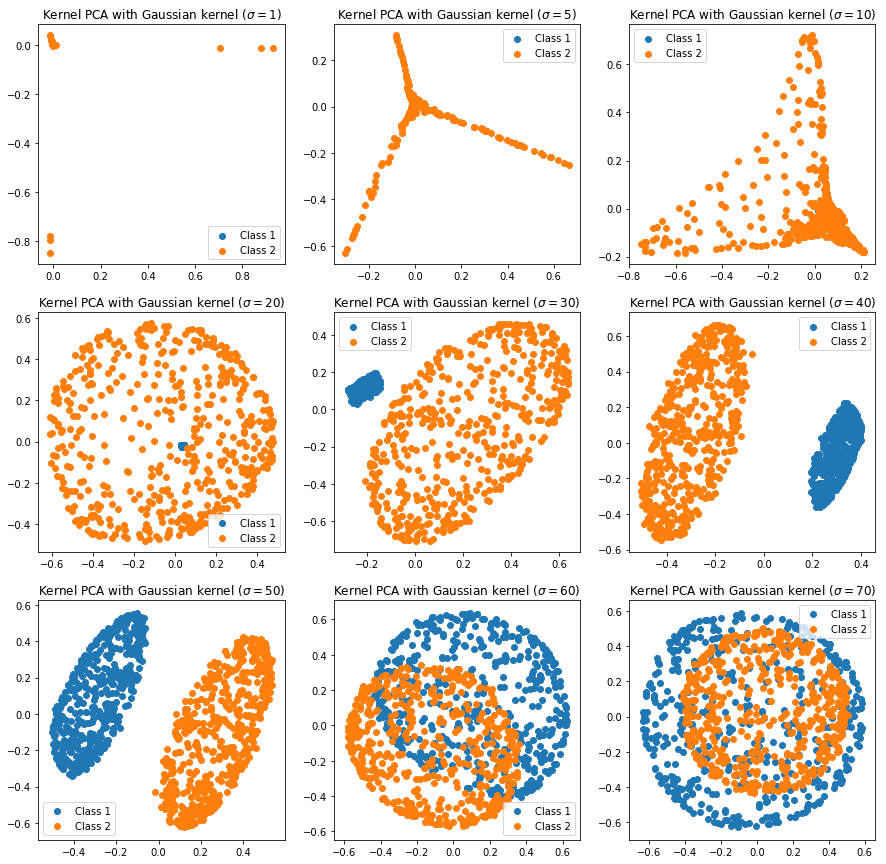

In [20]:
X, titles = [], []
data = np.array(synthetic_noise(1000, 100, 40, 1, False))
method = gaussian
for sigma in [1, 5, 10, 20, 30, 40, 50, 60, 70]:
    kpca = kernelPCA(method, {'sigma': sigma}, 2)
    train_new = kpca.fit_transform(data)
    X.append(train_new)
    titles.append(r'Kernel PCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma))
plot_results(X, figsize=(15, 15), titles=titles, grid=(3, 3))

Load MNIST dataset

In [25]:
path = '/Users/bfiliot/Desktop/ENSAE/3A/STATS_AV/'

def format(X):
    d = pd.DataFrame(X[0])
    d.columns = ['V'+str(i+1) for i in range(d.shape[1])]
    d['Y'] = X[1]
    return d

def load_data(path):
    zip_ref = zipfile.ZipFile(os.path.join(path, 'Data/mnist.pkl.gz'), 'r')
    zip_ref.extractall(os.path.join(path, 'Data'))
    zip_ref.close()
    train, valid, test = pickle.load(open(os.path.join(path, 'Data/mnist.pkl'), 'rb'), encoding='latin1')
    train, valid, test = format(train), format(valid), format(test) 
    return train, valid, test

train, valid, test = load_data(path)

In [ ]:
data = np.array(train[:5000])
method = polynomial
sigma = 10
kpca = kernelPCA(method, {'d': 1}, 2)
train_new = kpca.fit_transform(data)
plot_results([train_new], figsize=(8, 8), titles=[r'Kernel PCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma)], grid=(1, 1))

...Computing Gram matrix...


In [ ]:
test_new = kpca.transform(np.array(test[:100]))
plot_results([test_new], figsize=(8, 8), titles=[r'Kernel PCA with Gaussian kernel ($\sigma={:3.0f}$)'.format(sigma)], grid=(1, 1))